In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import cv2
import glob

In [2]:
car_images = glob.glob('vehicles/**/*.png')
noncar_images = glob.glob('non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


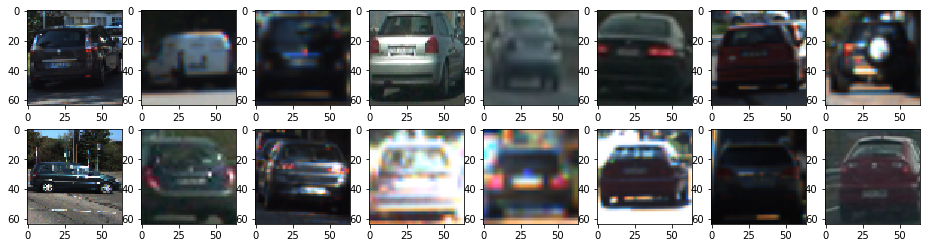

In [3]:
plt.figure(figsize=(16, 4))
for i in range(16):
    img = mpimg.imread(car_images[np.random.randint(0, len(car_images))])
    plt.subplot(2, 8, i+1)
    plt.imshow(img)

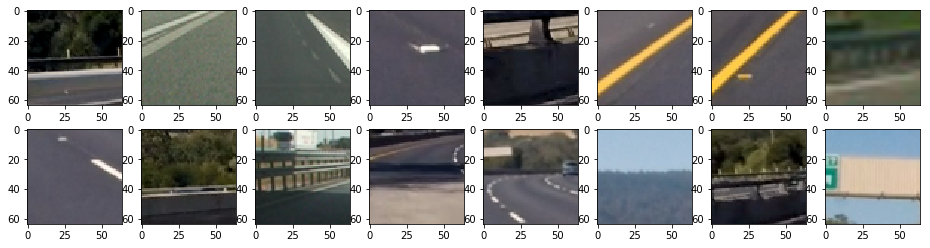

In [4]:
plt.figure(figsize=(16, 4))
for i in range(16):
    img = mpimg.imread(noncar_images[np.random.randint(0, len(noncar_images))])
    plt.subplot(2, 8, i+1)
    plt.imshow(img)

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

C:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


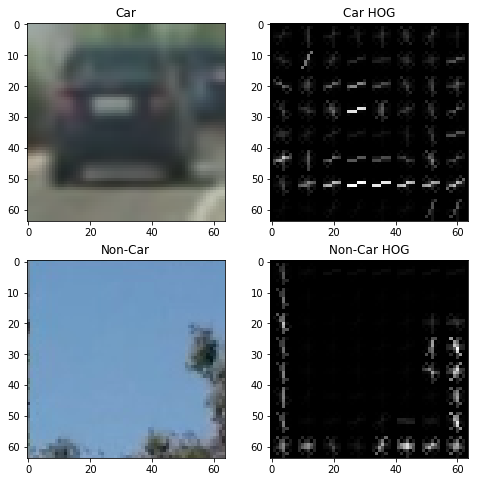

In [7]:
#visualize hog
car = mpimg.imread(car_images[0])
car_hog = get_hog_features(car[:,:,2], 9, 8, 2, vis=True, feature_vec=True)[1]

noncar = mpimg.imread(noncar_images[0])
noncar_hog = get_hog_features(noncar[:,:,2], 9, 8, 2, vis=True, feature_vec=True)[1]

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))

ax1.imshow(car)
ax1.set_title('Car', fontsize=12)
ax2.imshow(car_hog, cmap='gray')
ax2.set_title('Car HOG', fontsize=12)
ax3.imshow(noncar)
ax3.set_title('Non-Car', fontsize=12)
ax4.imshow(noncar_hog, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=12)

In [8]:
#extract hog features
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        # features.append(hog_features)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [9]:
cspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

In [10]:
car_features = extract_features(car_images, cspace=cspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=cspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

C:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [11]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [12]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=1)

In [14]:
X_train.shape

(14208, 8460)

In [15]:
svc = LinearSVC()

In [16]:
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [17]:
accuracy = round(svc.score(X_test, y_test),4)

In [18]:
print(accuracy)

0.9901


In [19]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [20]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32):
    found_windows = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                found_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, found_windows
    
ystart = 400
ystop = 656
scale = 1.5


In [21]:
#test on an example
img = mpimg.imread('test_images/test4.jpg')

In [22]:
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler)[0]

C:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [23]:
box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler)[1]

C:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


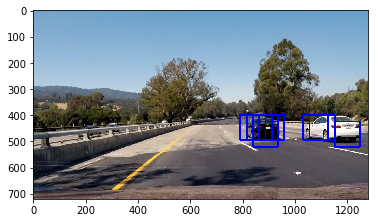

In [24]:
plt.imshow(out_img)

In [25]:
#test on all test images
test_images = list(map(lambda img: mpimg.imread(img), glob.glob('./test_images/*.jpg')))

C:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


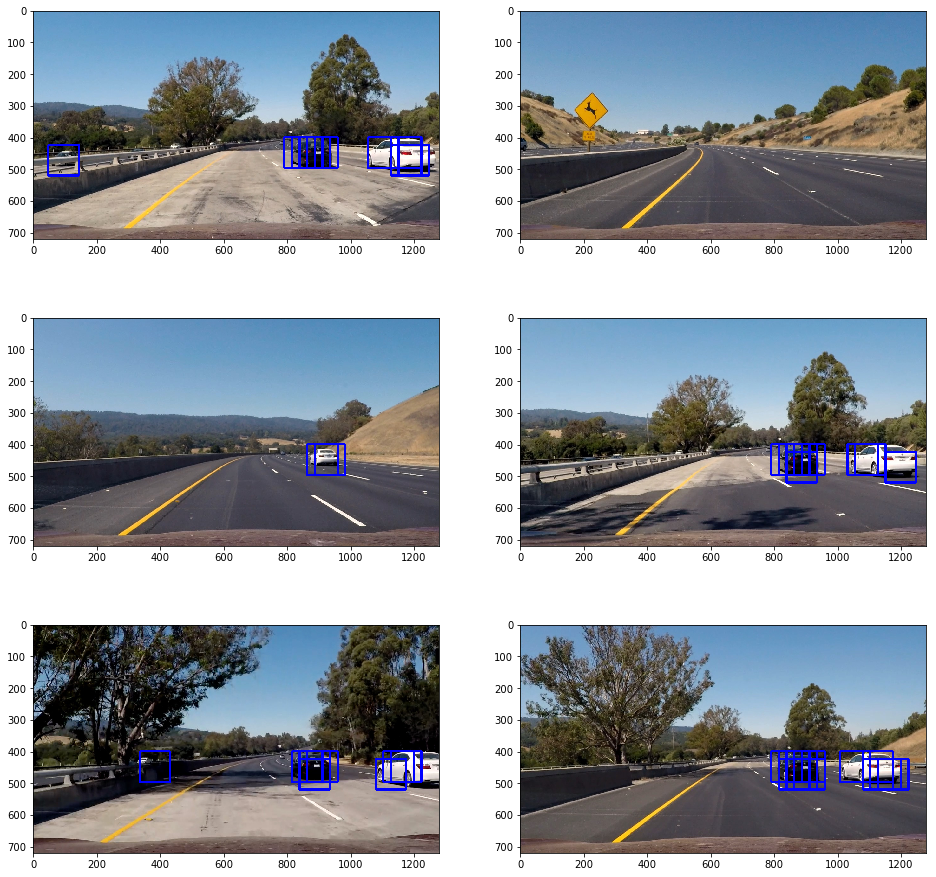

In [26]:
plt.figure(figsize=(16, 16))
for i, img in enumerate(test_images):
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler)[0]
    plt.subplot(3, 2, i+1)
    plt.imshow(out_img)

In [27]:
#heat map
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [28]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


In [29]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [30]:
#on test image
heat = np.zeros_like(img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

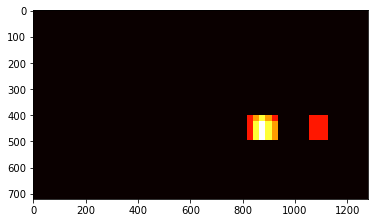

In [31]:
plt.imshow(heatmap, cmap='hot')

2 cars found


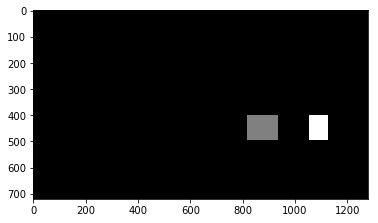

In [32]:
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

In [33]:
def draw_heat(img, boxes, threshold = 1):
    """
    draw the boxes after heat map on img
    """
    heatmap = add_heat(np.zeros(img.shape), boxes)
    heatmap = apply_threshold(heatmap, threshold)
    labels = label(heatmap)
    
    return draw_labeled_bboxes(np.copy(img), labels)

In [34]:
boxes = list(map(lambda img: find_cars(img, ystart, ystop, scale, svc, X_scaler)[1], test_images))

C:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [35]:
boxes_on_test = list(map(lambda img_and_boxes: draw_heat(img_and_boxes[0], img_and_boxes[1], threshold=1), zip(test_images, boxes)))

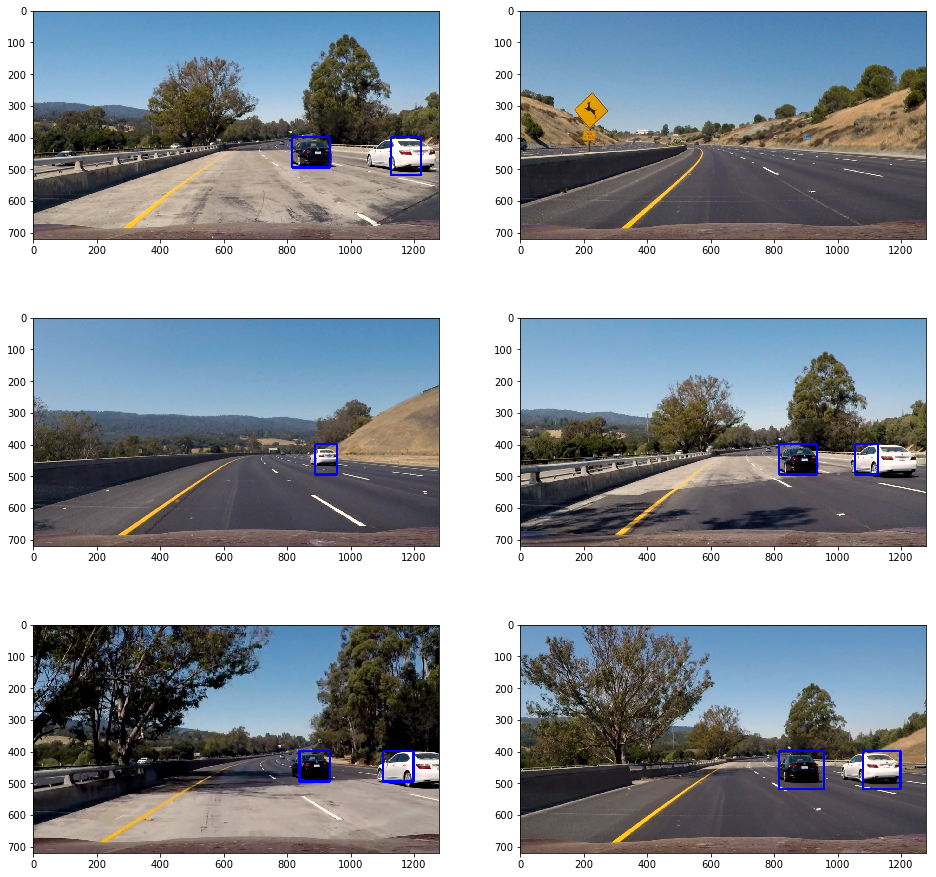

In [36]:
plt.figure(figsize=(16, 16))
for i, img in enumerate(boxes_on_test):
    plt.subplot(3, 2, i+1)
    plt.imshow(img)

In [37]:
def process_image(img):
    """
    Big pipeline for the video
    """
    boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, 
                      orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32)[1]
    out = draw_heat(img, boxes, threshold=1)
    return out

C:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


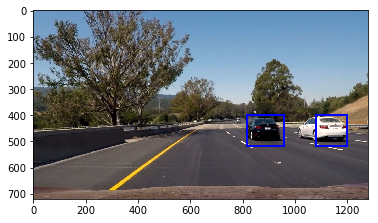

In [38]:
processed = process_image(img)
plt.imshow(processed)

In [39]:
from moviepy.editor import VideoFileClip
import time

In [40]:
video_output = 'test_video_output.mp4'
video_input = VideoFileClip('test_video.mp4')
processed_video = video_input.fl_image(process_image)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:23<00:00,  1.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 25.9 s


In [41]:
class Vehicle_History():
    def __init__(self):
        # save previous frame boxes
        self.prev_boxes = [] 
        
    def add_boxes(self, boxes):
        self.prev_boxes.append(boxes)
        if len(self.prev_boxes) > 25:
            # remove oldest boxes
            self.prev_boxes = self.prev_boxes[len(self.prev_boxes)-25:]

In [42]:
def process_image_track_prev(img):
    """
    Big pipeline for the video with frame tracking
    """
    boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, 
                      orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32)[1]
     
    if len(boxes) > 0:
        hist.add_boxes(boxes)
    heatmap_img = np.zeros_like(img[:,:,0])
    for box in hist.prev_boxes:
        heatmap_img = add_heat(heatmap_img, box)
    heatmap_img = apply_threshold(heatmap_img, 15 + len(hist.prev_boxes)//2)
     
    labels = label(heatmap_img)
    out = draw_labeled_bboxes(np.copy(img), labels)
    return out

In [44]:
hist = Vehicle_History()
video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(process_image_track_prev)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [09:42<00:00,  2.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 9min 44s


In [309]:
import pickle
pickle.dump(svc, open( "./model.p", "wb" ) )